In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
direc = Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream


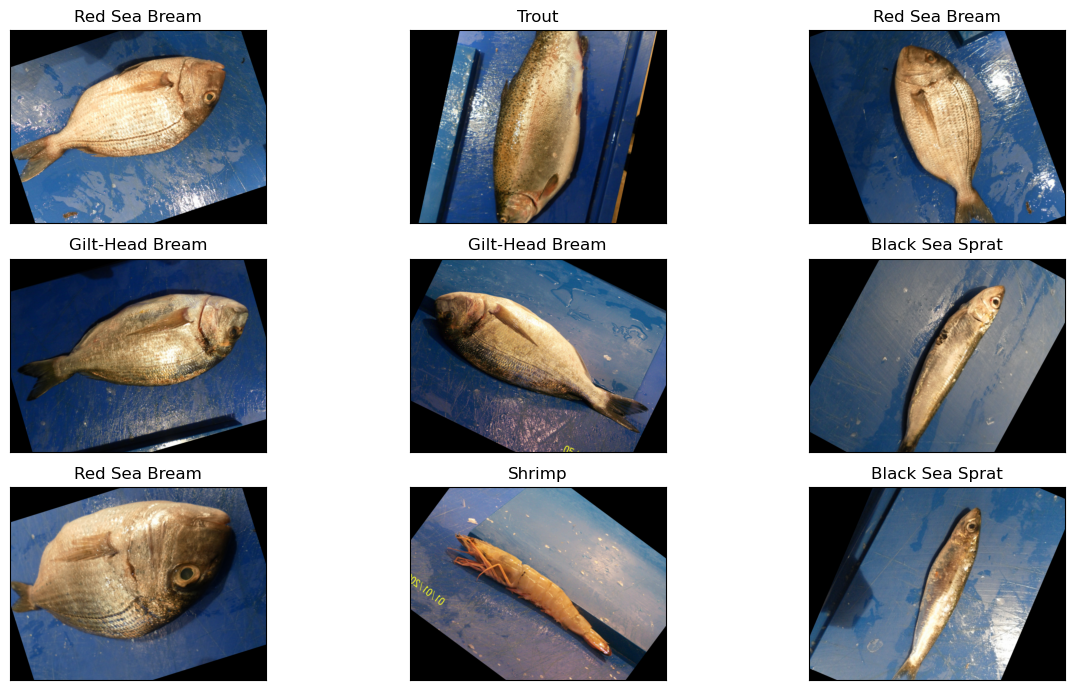

In [3]:
# Showing 9Images 
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


In [5]:
img_df['Labels'].value_counts(ascending=True)

Red Sea Bream         1000
Trout                 1000
Gilt-Head Bream       1000
Black Sea Sprat       1000
Shrimp                1000
Sea Bass              1000
Red Mullet            1000
Striped Red Mullet    1000
Hourse Mackerel       1000
Name: Labels, dtype: int64

In [6]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


In [7]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [8]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [9]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10
211/211 [==============================] - 169s 789ms/step - loss: 1.5270 - accuracy: 0.4468 - val_loss: 1.0829 - val_accuracy: 0.6167
Epoch 2/10
211/211 [==============================] - 78s 368ms/step - loss: 0.9267 - accuracy: 0.6812 - val_loss: 0.7246 - val_accuracy: 0.7378
Epoch 3/10
211/211 [==============================] - 78s 368ms/step - loss: 0.6560 - accuracy: 0.7766 - val_loss: 0.5740 - val_accuracy: 0.7900
Epoch 4/10
211/211 [==============================] - 77s 364ms/step - loss: 0.4810 - accuracy: 0.8354 - val_loss: 0.3601 - val_accuracy: 0.8744
Epoch 5/10
211/211 [==============================] - 79s 373ms/step - loss: 0.3566 - accuracy: 0.8807 - val_loss: 0.4015 - val_accuracy: 0.8522
Epoch 6/10
211/211 [==============================] - 80s 377ms/step - loss: 0.2937 - accuracy: 0.9001 - val_loss: 0.2523 - val_accuracy: 0.9100
Epoch 7/10
211/211 [==============================] - 77s 366ms/step - loss: 0.2103 - accuracy: 0.9304 - val_loss: 0.2292 - val_a

In [10]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 9) 

In [11]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 31s 736ms/step - loss: 0.1963 - accuracy: 0.9422
Test accuracy is :  94.22222375869751 %


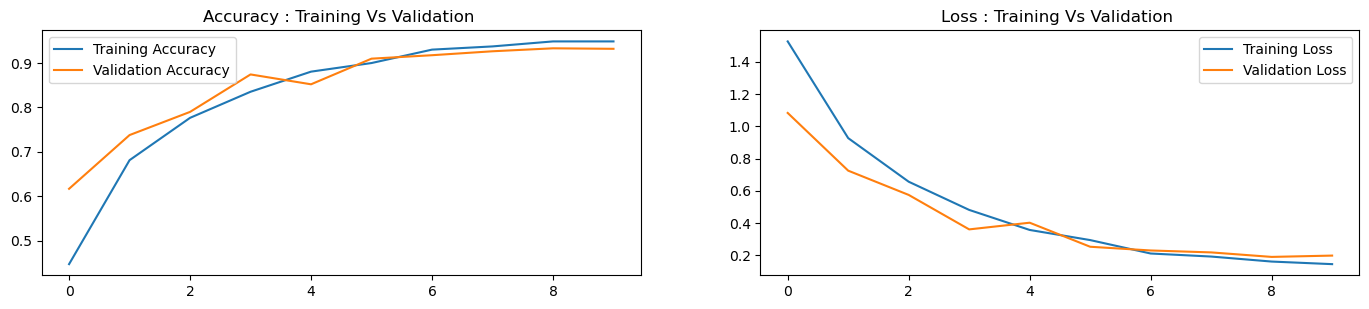

In [12]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()